Notebook dédié à l'analyse des données
- Statistiques descriptives
- Visualisation 

Validations sur le réseau : métro, RER, trains

In [2]:
import pandas as pd

df_rf = pd.read_csv("data/validations/validations_rf.csv", sep=";")

# Convertir la date
df_rf["JOUR"] = pd.to_datetime(df_rf["JOUR"], errors="coerce")

#stations les plus fréquentées (total)

traffic_rf = (
    df_rf.groupby(["CODE_STIF_ARRET", "LIBELLE_ARRET"])["NB_VALD"]
         .sum()
         .reset_index()
         .sort_values("NB_VALD", ascending=False)
)

traffic_rf.head(10)

,CODE_STIF_ARRET,LIBELLE_ARRET,NB_VALD
636,769,SAINT-LAZARE,10385453.0
682,822,SAINT-LAZARE,10173731.0
103,163,CHATELET,10131219.0
227,306,GARE DE LYON,9549672.0
294,393,LA DEFENSE,9522148.0
464,562,MONTPARNASSE,7733057.0
229,308,GARE DU NORD,6248706.0
232,313,GARE DE L'EST,5151198.0
354,460,LES HALLES,4444820.0
603,729,REPUBLIQUE,4296079.0


On a obtenu ci dessus un classement par "point d’arrêt technique"
Mais on peut avoir un même nom d’arrêt correspond à plusieurs “arrêts” techniques différents, donc plusieurs CODE_STIF_ARRET. C'est le cas ici pour Saint Lazare qui apparait 2 fois.
On peut aussi faire un classement par “station” au sens usager
→ il faut regrouper par LIBELLE_ARRET :

In [3]:
df_group = (
    df_rf.groupby("LIBELLE_ARRET", as_index=False)["NB_VALD"]
      .sum()
      .sort_values("NB_VALD", ascending=False)
)
df_group.head(10)

,LIBELLE_ARRET,NB_VALD
625,SAINT-LAZARE,20559184.0
148,CHATELET,13665229.0
284,GARE DE LYON,12328284.0
347,LA DEFENSE,10767994.0
456,MONTPARNASSE,10255590.0
285,GARE DU NORD,9182447.0
283,GARE DE L'EST,7987855.0
370,LES HALLES,4444820.0
599,REPUBLIQUE,4296079.0
125,CH.D.G.ETOILE,4217050.0


<Axes: xlabel='LIBELLE_ARRET'>

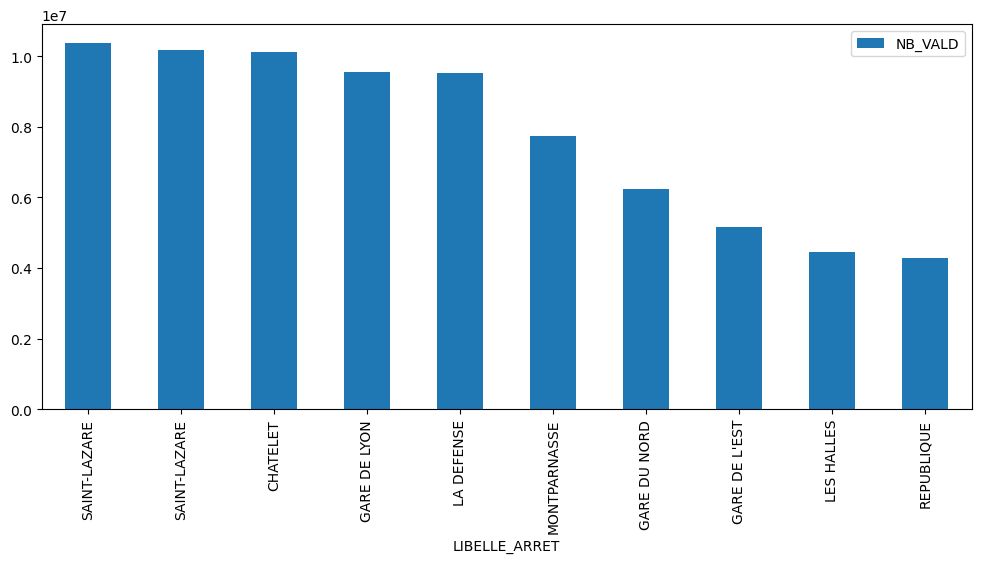

In [4]:
#Visualisation : 

traffic_rf.head(10).plot(
    kind="bar",
    x="LIBELLE_ARRET",
    y="NB_VALD",
    figsize=(12,5)
)


Nous pouvons essayer de visualiser sur une carte les proportions de validation :

In [8]:
!pip install geopy folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [folium]


In [10]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import os

# --- Chargement des validations ---
validations = pd.read_csv("data/validations/validations_rf.csv", sep=';')

# Agréger le nombre de validations par arrêt
traffic = validations.groupby('LIBELLE_ARRET')['NB_VALD'].sum().reset_index()
traffic = traffic.rename(columns={'LIBELLE_ARRET': 'stop_name', 'NB_VALD': 'nb_vald'})

# --- Géocodage avec cache ---
cache_file = "data/stations_coords.csv"

if os.path.exists(cache_file):
    # Charger les coordonnées si elles existent déjà
    coords = pd.read_csv(cache_file)
else:
    # Sinon, géocoder puis sauvegarder
    geolocator = Nominatim(user_agent="my_app")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

    def get_coords(name):
        location = geocode(f"{name}, Paris, France")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None

    traffic['lat'], traffic['lon'] = zip(*traffic['stop_name'].map(get_coords))

    # Sauvegarde dans le cache
    traffic[['stop_name','lat','lon']].to_csv(cache_file, index=False)
    coords = traffic[['stop_name','lat','lon']]

# Merge coordonnées avec trafic
traffic = pd.merge(traffic, coords, on='stop_name', how='left')

# Supprimer les arrêts sans coordonnées
traffic = traffic.dropna(subset=['lat', 'lon'])

# Normaliser rayon pour la visualisation
max_radius = 30
traffic['radius'] = traffic['nb_vald'] / traffic['nb_vald'].max() * max_radius
traffic['radius'] = traffic['radius'].clip(lower=2)

# --- Création de la carte ---
m = folium.Map(location=[48.85, 2.35], zoom_start=12)

for _, row in traffic.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=row['radius'],
        color='red',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['stop_name']}: {int(row['nb_vald']):,}"
    ).add_to(m)

m



RateLimiter caught an error, retrying (0/2 tries). Called with (*('AEROPORT CDG2, Paris, France',), **{}).
Traceback (most recent call last):
  File "/opt/python/lib/python3.13/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "/opt/python/lib/python3.13/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
  File "/opt/python/lib/python3.13/http/client.py", line 1430, in getresponse
    response.begin()
    ~~~~~~~~~~~~~~^^
  File "/opt/python/lib/python3.13/http/client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ~~~~~~~~~~~~~~~~~^^
  File "/opt/python/lib/python3.13/http/client.py", line 292, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(

KeyError: ['lat', 'lon']

In [38]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# --- Chargement des validations ---

validations = pd.read_csv("data/validations/validations_rf.csv", sep=';')

# Agréger le nombre de validations par arrêt

traffic = validations.groupby('LIBELLE_ARRET')['NB_VALD'].sum().reset_index()
traffic = traffic.rename(columns={'LIBELLE_ARRET': 'stop_name', 'NB_VALD': 'nb_vald'})

# --- Géocodage des noms de stations ---

geolocator = Nominatim(user_agent="my_app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)  # pour ne pas spammer le service

# Fonction pour géocoder

def get_coords(name):
    location = geocode(f"{name}, Paris, France")
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

traffic['lat'], traffic['lon'] = zip(*traffic['stop_name'].map(get_coords))

# Supprimer les arrêts sans coordonnées

traffic = traffic.dropna(subset=['lat', 'lon'])

# Normaliser rayon pour la visualisation

max_radius = 30
traffic['radius'] = traffic['nb_vald'] / traffic['nb_vald'].max() * max_radius
traffic['radius'] = traffic['radius'].clip(lower=2)

# --- Création de la carte ---

m = folium.Map(location=[48.85, 2.35], zoom_start=12)

for _, row in traffic.iterrows():
    folium.CircleMarker(
    location=[row['lat'], row['lon']],
    radius=row['radius'],
    color='red',
    fill=True,
    fill_opacity=0.6,
    popup=f"{row['stop_name']}: {int(row['nb_vald']):,}"
    ).add_to(m)

m  # affichage de la carte


RateLimiter caught an error, retrying (0/2 tries). Called with (*('AEROPORT CDG1, Paris, France',), **{}).
Traceback (most recent call last):
  File "/opt/python/lib/python3.13/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "/opt/python/lib/python3.13/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
  File "/opt/python/lib/python3.13/http/client.py", line 1430, in getresponse
    response.begin()
    ~~~~~~~~~~~~~~^^
  File "/opt/python/lib/python3.13/http/client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ~~~~~~~~~~~~~~~~~^^
  File "/opt/python/lib/python3.13/http/client.py", line 292, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
               ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/opt/python/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(